# Import libraries

In [1]:
import scipy as sc
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import pyccl as ccl
from mpl_toolkits import mplot3d

# Add real data

In [2]:
# --- ADD OUR DATA for fsigma_8 ----

z_data = [0.02,0.067,0.1,0.17,0.35,0.77,0.25,0.37,0.22,0.41,0.6,0.6,0.78,0.57,0.3,0.4,0.5,0.8]
fsigma8_data = [0.36,0.423,0.37,0.51,0.44,0.49,0.351,0.46,0.42,0.45,0.43,0.433,0.38,0.427,0.407,0.419,0.427,0.47]
err_data = [0.04,0.055,0.13,0.06,0.05,0.18,0.058,0.038,0.07,0.04,0.04,0.067,0.04,0.066,0.055,0.041,0.043,0.08]

# Find growth rate f to first order

In [84]:
#---- USEFUL FUNCTIONS for growth rate f ----

# Define xi, caracteristic function of 4DEGB. xi(alpha_C = 1) = 1
# note: k is unitless (ie. k is actually k/H0)
def xi(x, cosmo):
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_C, k = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = 1 - Omega_m - Omega_r - Omega_k - alpha_C
    
    return k**2/(k**2 + 6*alpha_C*np.exp(-2*x))

def E(x,cosmo):
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_C, k = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = 1 - Omega_m - Omega_r - Omega_k - alpha_C
    
    return np.sqrt(Omega_m*np.exp(-3*x) + (Omega_r + alpha_C)*np.exp(-4*x) + Omega_k*np.exp(-2*x) +Omega_lambda)

# derivative of the growth rate f with the logarithm of the scale factor x = ln(a) 
def dfdx(f , x , cosmo):
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_C, k = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = 1 - Omega_m - Omega_r - Omega_k - alpha_C
    
    return (3*Omega_m * np.exp(-3*x) *xi(x,cosmo)/(2*E(x,cosmo)**2)) - f**2 \
          - (2 -(3*Omega_m*np.exp(-3*x) + 4*(Omega_r + alpha_C)*np.exp(-4*x) \
                 + 2*Omega_k*np.exp(-2*x))/(2*E(x,cosmo)**2))*f


In [112]:
# ---- COSMOLOGY, SCALES AND BOUNDARY CONDITIONS -----

# Decide on some background cosmology
# note: k is unitless (ie. k is actually k/H0)
# for simga_8, k = 2pi/(8h^-1 Mpc) \implies k/H0 = 3e5*pi/400

k_val = np.linspace(4, 3e5*np.pi/200, int(1e3))
cosmo = [0.27 , 0.045, 0 ,9.227e-5 , 1e-5 , k_val]
cosmo_LCDM_array = [0.27 , 0.045, 0 ,9.227e-5 , 0.0 , 0.1]

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

idx_sigma = find_nearest(k_val, 3e5*np.pi/400)
print("error in k_simga8 = ", 100*abs(3e5*np.pi/400 - k_val[idx_sigma])/(3e5*np.pi/400), "%")

# Background cosmology for pyccl
cosmoLCDM = ccl.core.Cosmology(Omega_c=cosmo[0],
                               Omega_b=cosmo[1], 
                               sigma8=0.81,
                               h = 0.67,
                               n_s=0.96,
                               Omega_k=cosmo[2], 
                               Omega_g=cosmo[3])

# Decide on some coordinate times
p = 4
x = np.linspace( -3, 0 , int(10**p))
a = np.exp(x)
z = 1/a - 1

# create boundary condition for f: in matter dominated universe (Omg_m*(1+z)**3 >> Omg_l, Omg_m >> Omg_r*(1+z)) D(a) = a, f(a) = 1
z_BC = z[0] # Redshift our BC occurs at
print("z_BC = ", z_BC)

# correction due to not being in matter-dominated era
def Cort3(cosmo, z_BC):
    return (cosmo[3]+cosmo[4])*(1+z_BC)/(cosmo[0] + cosmo[1])

# correction due to large xi = small wavevector
def Cort_xi(cosmo, z_BC):
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_C, k = cosmo
    return 18*alpha_C*(1+z_BC)**2/k**2

# Ensures we use the BCs only if we are at an initial redshift of matter domination
def BoundaryCondition(z_BC,cosmo):
    # ensure error message pops up if errors are too big
    if 1 < Cort3(cosmo, z_BC).any():
        ans = "Not in matter-dominated era. We need alpha_C = ", 1/((4*(cosmo[0]  + cosmo[1])*(1+z_BC)) - cosmo[3])
        print(ans)
    elif 1 < Cort_xi(cosmo, z_BC).any():
        ans = "k is too small and we are not in matter domination. Need k = ", np.sqrt(18*cosmo[-2]*(1+z_BC)**2)
        print(ans)
    else:
        ans = 1 - 2*Cort3(cosmo,z_BC)/3 + Cort_xi(cosmo, z_BC)
    return ans

# errors in our estimates of the BC
BC_err = Cort3(cosmo, z_BC)**2 + Cort_xi(cosmo, z_BC)**2
BC_err_LCDM = Cort3(cosmo_LCDM_array, z_BC)**2 

BC = BoundaryCondition(z_BC,cosmo)
BC_LCDM = BoundaryCondition(z_BC,cosmo_LCDM_array)

error in k_simga8 =  0.015132496180504551 %
z_BC =  19.085536923187668


In [113]:
# --- FINDING SOLUTIONS ------

#find solution - 4DEGB
f = odeint(dfdx, BC, x, args=(cosmo,), mxstep=int(1e4))
f = np.transpose(f)
#find solution - LCDM
f_LCDM = odeint(dfdx, BC_LCDM, x, args=(cosmo_LCDM_array,), mxstep=int(1e4))
f_LCDM = np.transpose(f_LCDM)[0]

#find solution's theoretical error - 4DEGB
# Order of magnitude estimate of maximum BC if we assume ~ second order correction
f_max = odeint(dfdx, BC + BC_err, x, args=(cosmo,), mxstep=int(1e4))
f_max = np.transpose(f_max)

f_min = odeint(dfdx, BC - BC_err, x, args=(cosmo,), mxstep=int(1e4))
f_min = np.transpose(f_min)

#find solution's theoretical error - equivalent LCDM universe
# Order of magnitude estimate of maximum BC if we assume ~ second order correction
f_max_LCDM = odeint(dfdx, BC_LCDM + BC_err_LCDM, x, args=(cosmo_LCDM_array,), mxstep=int(1e4))
f_max_LCDM = np.transpose(f_max_LCDM)[0]

f_min_LCDM = odeint(dfdx, BC_LCDM - BC_err_LCDM, x, args=(cosmo_LCDM_array,), mxstep=int(1e4))
f_min_LCDM = np.transpose(f_min_LCDM)[0]


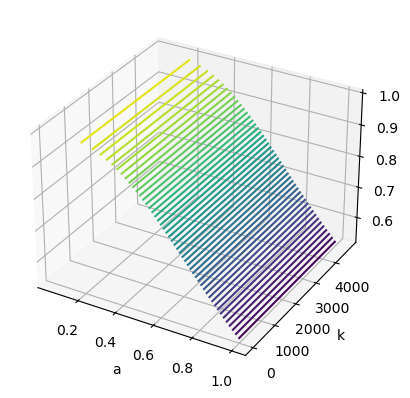

In [114]:
# 3D plot of f(a,k)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(a, k_val, f, 50)
ax.set_xlabel('a')
ax.set_ylabel('k')
ax.set_zlabel('f');

# Plot growth rate f and the fractional difference to LCDM

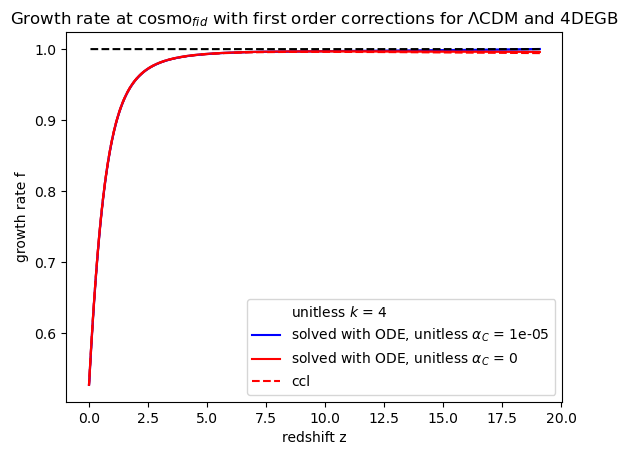

In [123]:
# plot of the growth rate with theoretical errors to to initial BC assumption, LDCM and 4DEGB
# function of z

plt.title(r"Growth rate at cosmo$_{fid}$ with first order corrections for $\Lambda$CDM and 4DEGB")
plt.plot(0,0.8,color = "white", label = r"unitless $k$ = {}".format(int(cosmo[-1][0])))
plt.plot(z,f[0], color = "b", label = r"solved with ODE, unitless $\alpha_C$ = {}".format(cosmo[-2]))
plt.fill_between(z, f_min[0], f_max[0], alpha=0.5, edgecolor='b', facecolor='b')

plt.plot(z,f_LCDM, color = "r", label = r"solved with ODE, unitless $\alpha_C$ = 0")
plt.fill_between(z, f_min_LCDM, f_max_LCDM, alpha=0.5, edgecolor='r', facecolor='r')

plt.plot(z, ccl.growth_rate(cosmoLCDM,a), color = "r", linestyle='dashed', label = "ccl")

plt.plot(z, np.ones(len(z)), color = "black", linestyle = "dashed")

#plt.plot(z[7000:], ((cosmo[0] + cosmo[1])*(1+z[7000:])**3/E(x[7000:],cosmo))**0.55, color = "gray", linestyle = "dashed", label = r"$\Omega_m(a)^{0.55}$")

plt.xlabel("redshift z")
plt.ylabel("growth rate f")
#plt.xscale('log')
plt.legend()
plt.show()

# Find Delta(a) and sigma8 to first order

In [124]:
#---- USEFUL FUNCTIONS for Delta(a) and sigma8 -----

# Solves second order ODE for D_+(a)
def solverGrowth(y,a,cosmo):
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_C, k = cosmo
    Omega_m = Omega_c + Omega_b

    E_val = E(np.log(a), cosmo)
    
    D , a3EdDda = y
    
    ydot = [a3EdDda / (E_val*a**3), 3*Omega_m*D*xi(np.log(a), cosmo)/(2*E_val*a**2)]
    return ydot

In [125]:
# ---- BOUNDARY CONDITIONS -------

# Can also do present day normalization as D(a = 1) = 1 (derivative?)
# Normalization to matter dominated epoc, D(a) = a * (1 - 3 Cort1 /2 -2 Cort2 /11)
# ======> dDda = 1 + 3 Cort1 - 8 Cort2 /11

Da_BC = a[0] * (1 + 2*Cort3(cosmo, z_BC)/3 - Cort_xi(cosmo, z_BC)/2)
Da_BC_LCDM = a[0] * (1 + 2*Cort3(cosmo_LCDM_array, z_BC)/3)
Da_BC_max = a[0] * (1 + 2*Cort3(cosmo, z_BC)/3 - Cort_xi(cosmo, z_BC)/2 + BC_err)
Da_BC_min = a[0] * (1 + 2*Cort3(cosmo, z_BC)/3 - Cort_xi(cosmo, z_BC)/2 - BC_err)
Da_BC_LCDM_max = a[0] * (1 + 2*Cort3(cosmo_LCDM_array, z_BC)/3 + BC_err_LCDM)
Da_BC_LCDM_min = a[0] * (1 + 2*Cort3(cosmo_LCDM_array, z_BC)/3 - BC_err_LCDM)

# BC for 4DEGB 
BCs = [Da_BC, (E(np.log(a[0]), cosmo)*a[0]**3)]

# Order of magnitude estimate of maximum BC if we assume ~ second order correction
BCs_max = [Da_BC_max, (E(np.log(a[0]), cosmo)*a[0]**3)]

BCs_min = [Da_BC_min, (E(np.log(a[0]), cosmo)*a[0]**3)]

# BC for LCDM
BCs_LCDM = [Da_BC_LCDM, (E(np.log(a[0]), cosmo_LCDM_array)*a[0]**3)]

# Order of magnitude estimate of maximum BC if we assume ~ second order correction
BCs_LCDM_max = [Da_BC_LCDM_max, (E(np.log(a[0]), cosmo_LCDM_array)*a[0]**3)]

BCs_LCDM_min = [Da_BC_LCDM_min, (E(np.log(a[0]), cosmo_LCDM_array)*a[0]**3)]

In [126]:
# ---- SOLUTIONS -------

#4DEGB solution - Delta[:,1] is Delta as a function of k, Delta[1,:] is Delta as a function of a
Soln = np.zeros((len(k_val),len(a)))
for i in range(len(k_val)):
    Soln[i] = odeint(solverGrowth, [BCs[0][i],BCs[1]], a, args=([cosmo[0],cosmo[1],cosmo[2],cosmo[3],cosmo[4],cosmo[5][i]],), mxstep=int(1e4)).T[0]

Delta = np.zeros((len(k_val),len(a)))
for j in range(len(Soln[:,-1])):
    Delta[j] = Soln[j]/Soln[j,-1]
    
# 4DEGB error
for i in range(len(k_val)):
    Soln[i] = odeint(solverGrowth,  [BCs_max[0][i],BCs_max[1]], a, args=([cosmo[0],cosmo[1],cosmo[2],cosmo[3],cosmo[4],cosmo[5][i]],), mxstep=int(1e4)).T[0]

Delta_max = np.zeros((len(k_val),len(a)))
for j in range(len(Soln[:,-1])):
    Delta_max[j] = Soln[j]/Soln[j,-1]
    
for i in range(len(k_val)):
    Soln[i] = odeint(solverGrowth,  [BCs_min[0][i],BCs_min[1]], a, args=([cosmo[0],cosmo[1],cosmo[2],cosmo[3],cosmo[4],cosmo[5][i]],), mxstep=int(1e4)).T[0]

Delta_min = np.zeros((len(k_val),len(a)))
for j in range(len(Soln[:,-1])):
    Delta_min[j] = Soln[j]/Soln[j,-1]

# LCDM solution
Soln = odeint(solverGrowth, BCs_LCDM, a, args=(cosmo_LCDM_array,), mxstep=int(1e4))
Delta_LCDM = Soln.T[0]/Soln.T[0][-1]

#LCDM error
Soln = odeint(solverGrowth, BCs_LCDM_max, a, args=(cosmo_LCDM_array,), mxstep=int(1e4))
Delta_LCDM_max = Soln.T[0]/Soln.T[0][-1]

Soln = odeint(solverGrowth, BCs_LCDM_min, a, args=(cosmo_LCDM_array,), mxstep=int(1e4))
Delta_LCDM_min = Soln.T[0]/Soln.T[0][-1]

# Plot Delta(a) or sigma8 and fsigma_8

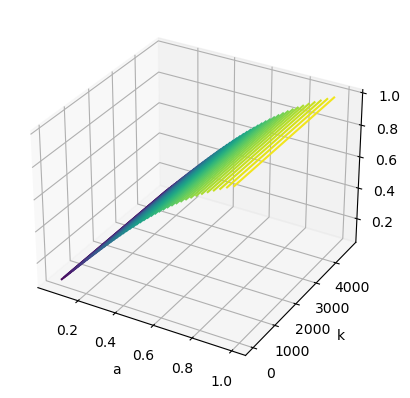

In [127]:
# 3D plot of Delta(a,k)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(a, k_val, Delta, 50)
ax.set_xlabel('a')
ax.set_ylabel('k')
ax.set_zlabel('f');

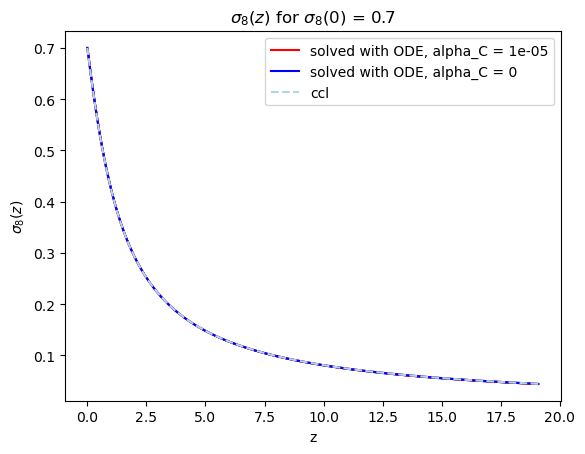

In [128]:
# plot of sigma_8(z)
sigma8 = 0.7
plt.plot(z, sigma8*Delta[idx_sigma], label  = r"solved with ODE, alpha_C = {}".format(cosmo[-2]), color = "r")
plt.fill_between(z, sigma8*Delta_min[idx_sigma], sigma8*Delta_max[idx_sigma], alpha=0.5, edgecolor='r', facecolor='r')

plt.plot(z, sigma8*Delta_LCDM, label  = r"solved with ODE, alpha_C = 0", color = "blue")
plt.fill_between(z, sigma8*Delta_LCDM_min, sigma8*Delta_LCDM_max, alpha=0.5, edgecolor='blue', facecolor='blue')

plt.plot(z, sigma8*ccl.growth_factor(cosmoLCDM,a), label = "ccl", color = "lightblue", linestyle ="--")
plt.legend()

plt.xlabel("z")
plt.ylabel(r"$\sigma_8(z)$")
plt.title(r"$\sigma_8(z)$ for $\sigma_8(0)$ = {}".format(sigma8))
plt.show()

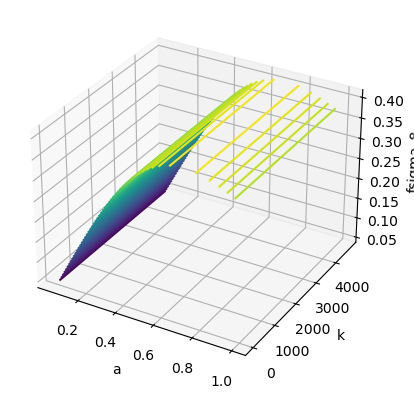

In [129]:
# Plot of fsimga_8(a,k)
# 3D plot of Delta(a,k)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(a, k_val, sigma8*f*Delta[idx_sigma], 50)
ax.set_xlabel('a')
ax.set_ylabel('k')
ax.set_zlabel('fsigma_8');

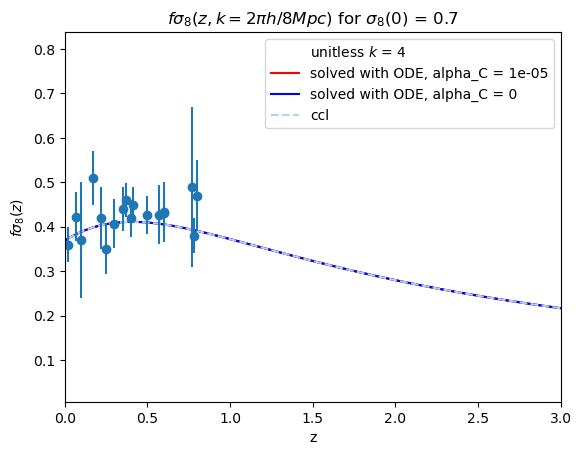

In [130]:
plt.plot(0,0.8,color = "white", label = r"unitless $k$ = {}".format(int(cosmo[-1][0])))

plt.plot(z,sigma8*f[0]*Delta[idx_sigma], label = r"solved with ODE, alpha_C = {}".format(cosmo[-2]), color = "r")
plt.fill_between(z, sigma8*f_min[0]*Delta_min[idx_sigma], sigma8*f_max[0]*Delta_max[idx_sigma], alpha=0.5, edgecolor='r', facecolor='r')

plt.plot(z,sigma8*f_LCDM*Delta_LCDM, label = "solved with ODE, alpha_C = 0", color = "b")
plt.fill_between(z, sigma8*f_min_LCDM*Delta_LCDM_min, sigma8*f_max_LCDM*Delta_LCDM_max, alpha=0.5, edgecolor='b', facecolor='b')

plt.plot(z,sigma8*ccl.growth_rate(cosmoLCDM,a)*ccl.growth_factor(cosmoLCDM,a), label = "ccl", color = "lightblue", linestyle ="--")
plt.legend()

# plot our data
plt.errorbar(z_data, fsigma8_data, yerr=err_data, fmt="o", label='data')

plt.xlabel("z")
plt.ylabel("$f\sigma_8(z)$")
plt.title(r"$f\sigma_8(z, k = 2 \pi h/8 Mpc)$ for $\sigma_8(0)$ = {}".format(sigma8))

plt.xlim(0,3)
plt.show()